# Spectrogram Maker

## Liam Kelly

The purpose of this notebook is to create a spectrogram creating function which converts wav files to spectrograms.

Spectrograms can be though of as visual representations of sounds. The 2-D images show time on the x-axis, and the frequencies of the sound on the y-axis. Thus the spectrogram provides a method of seeing how the frequency components of a sound wave evolve over time. 

The spectrogram function loads in wav files by converting them to a wavefore (a representation of the acosutic amplitude vs. time). From here the program splits the audio file into smaller time segments called 'windows'. For each window, a linear ramp is applied to both sides to make the sound data in the window appear like a pulse (This helps with preventing deleterious frequency components from appearing in the final spectrogram). The FFT is applied to the pulse-like window, and frequency components are returned. The final spectrogram is created by stiching together all the frequency components for each windowed segment together.

The spectrogram making function is written below:

In [1]:
# Import packages: 
import os
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram
from scipy.signal import detrend
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

In [2]:
def my_spectrogram(x, s_rate, window_s = None, n_overlap = None, n_ramp = 10, pad = True, pad_l = 10, trend = True, scale = 'log'):
    
    '''
    Creates a spectrogram from waveform data.
    
    Parameters
    ----------
    x: waveform input. (One dimensional array)
    s_rate: The sampling rate of the waveform (Hz). (int or float)
    window_s: The number of data points to be included in each window. (int)
    n_overlap: The number of data points which overlap between windows. (int)
    n_ramp: The number of data points to include in the linear ramp at the beginning and end of each window. (int)
    pad: Whether or not to zero pad the beginning and end of each window for enhanced frequency resolution. (Bool)
    pad_l: How many zeros to pad if zero padding is being applied. (int)
    trend: Whether or not to detrend the windowed data (remove linear trend) (Bool)
    scale: Determines the scale of the output. If 'log' then the output is in log scale, if not it is linear scale. (string)
    
    
    Returns
    -------
    spec: The spectrogram of x (Numpy array)
    
    Examples
    --------
    >>>> 
    >>>> my_spec([53,   55,   40, ..., -137, -152, -180], s_rate = 16000)
    array([[ -4.44082053,   0.05745326, -12.13444582, ...,   2.02364537,
         10.61266715,  -7.94253133],
       [  3.68863883,   4.06651478,   2.33509789, ...,   9.75734083,
          8.19811069,  10.67875059],
       [  2.26672087,   4.0432509 ,   2.07712235, ...,   9.76021916,
          9.36027837,   7.84550269],
       ...,
       [-15.26584908, -12.14423326, -12.8131388 , ..., -19.60461474,
        -11.17298244, -16.09601653],
       [-16.85551165, -12.38802169, -11.57363368, ..., -14.96483003,
        -11.04082264, -19.56943179],
       [-14.36945594, -10.03673617, -11.34501539, ..., -12.57705663,
        -15.64148351, -11.8356727 ]])
    '''
    
    
    
    from scipy.fft import fft, fftfreq
    import numpy as np
    from scipy.signal import detrend
    
    # Initialize parameters:
    n_t =len(x) # Obtain the length of the time domain signal
    if window_s == None:
        window_s = int(n_t/50) # Choose the size of the window to perform Fourier transforms over
        print(window_s)
    if n_overlap == None:
        n_overlap = int(window_s*1/8) # chose the number of points to overlap between segments.
    step_size = window_s - n_overlap # Number of data points between FFT steps.
    n_FFTs = int((n_t-window_s)/step_size) # Total number of FFTs.
    
    # Perform FFT over each slice of time domain data:
    if pad == True:
        spect = np.zeros([int((window_s + 2*pad_l)/2), n_FFTs]) # Initialize the spectrogram array.
    if pad == False:
        spect = np.zeros([int(window_s/2), n_FFTs]) # Initialize the spectrogram array.
    for i in range(n_FFTs):
        x_c = x[i*step_size: i*step_size + window_s] # Slice out data for the current window.
        
        # Detrend the data to prevent computational artifacts near low frequencies:
        if trend == True:
            x_c = detrend(x_c)
            
        # Linear scale first and last values to make pulse-like and prevent delta function at window edges:
        x_c[:n_ramp] = x_c[:n_ramp]*np.linspace(0,1,n_ramp)
        x_c[-n_ramp:] = x_c[-n_ramp:]*np.linspace(1,0,n_ramp)
        
        # Give the use the option to zero pad the windowed audio segments to enhance the frequency resolution of the final spectrogram:
        if pad == True:
            x_c = np.pad(x_c, pad_l, mode = 'constant') # Add 0s to either end of the window
        n = len(x_c)
        
        # Perform the FFT on the current slice
        X_c = 2/n * (np.abs(fft(x_c)[:n//2]))
        
        # Transform the data to log scale if scale is set to 'log'
        if scale == 'log':
            X_c = 10*np.log10(X_c)
            
        # Append the data from the current window to the spectrogram array:
        spect[:,i] = X_c
        
    return spect

Now that the spectrogram function has been created, we can test its output against the output of scipy's spectrogram function:

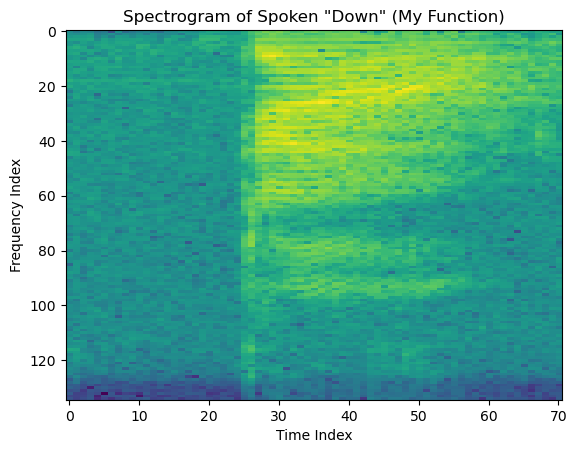

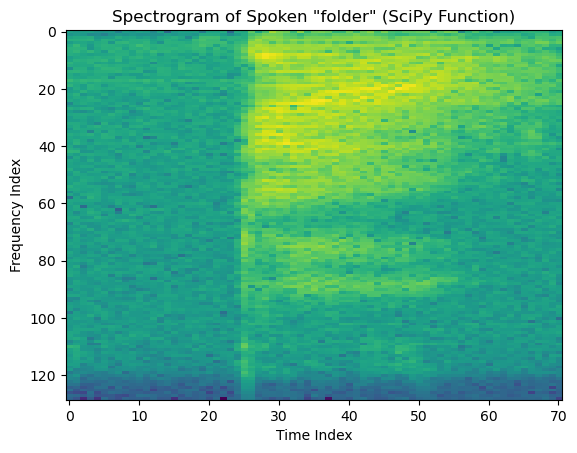

In [3]:
# Test my function and compare with the scipy function:

# Import the data:
s_rate, data = wavfile.read('data/down/00b01445_nohash_1.wav')
# Calculate the spectrogram from the above data:
spec = my_spectrogram(data, s_rate, window_s = 250, n_ramp = 50)

# Plot the resulting spectrogram:
plt.imshow(spec, cmap='viridis', aspect = 'auto', interpolation = 'nearest')
plt.xlabel('Time Index')
plt.ylabel('Frequency Index')
plt.title('Spectrogram of Spoken "Down" (My Function)')
plt.show()  

# Calculate the spectrogram using scipy's function:
x= spectrogram(data, s_rate, mode = 'magnitude')

# Plot the resulting spectrogram:
plt.imshow(np.log(x[2]), cmap='viridis', interpolation='nearest', aspect = 'auto')
plt.title('Spectrogram of Spoken "%s" (SciPy Function)' % 'folder')
plt.xlabel('Time Index')
plt.ylabel('Frequency Index')
plt.show()

We can see that the output from both functions are effectively identical!

Now we will use a for loop to loop through all the audio samples from the "Speech Commands: A Dataset for Limited-Vocabulary Speech Recognition" dataset. The resulting spectrogram from each audio file will be saved in a folder with the name of the spoken word. 

In [7]:
###############################
########### Inputs ############

folder= 'data/'

###############################

j=1 # Initialize the folder progress counter
for subfolder in os.listdir(folder): # iterate through each subfolder in the data folder
    
    path = folder + subfolder + '/' # Create a path for the subfolder
    
    #Print the current progress
    print('Currently processing the \033[1m%s\033[0m subfolder... (%i/%i)        ' % (subfolder, j, len(os.listdir(folder))), end = '\r')
    
    j += 1# Increase the subfolder progress counter by 1.
    
    # Iterate through each sound file in the subfolder:
    for item in os.listdir(path):
        
        # Load the data
        s_rate, x = wavfile.read(path + item)
        
        # Compute the spectrogram:
        spec = my_spectrogram(x, s_rate, window_s = 250, n_ramp = 50)
        
        # Save the spectrogram:
        np.save('spectrogram/' + subfolder + '/' + item[:-4], spec)  

# Print the completed status:
print('Done!                                                  ', end = '\r')      

C:\Users\liamg\AppData\Local\Temp\ipykernel_2888\894052206.py:47: RuntimeWarning: divide by zero encountered in log10
  X_c = 10*np.log10(X_c)
